In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.interpolate import splrep, BSpline, CubicSpline
from scipy.special import gammainc
from scipy.optimize import brentq
from scipy.stats import norm
from numpy import prod, round, abs, array
import matplotlib.pyplot as plt
from sklearn import datasets
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import math

# Establece la semilla para la generación de números aleatorios
np.random.seed(1)
x = np.random.normal(size=100, loc=2)
y = np.random.normal(size=100, loc=5)

# Función que calcula una funció de un conjunto de datos
def T(x):
  return mean(x)

# Función para calcular la media aritmética de un arreglo
def mean(x) -> float:
  return sum(x)/len(x)

# Función que calcula la media cuadrática (RMS) de un arreglo
def sq_mean(x) -> float:
  return np.sqrt(sum(x**2)/len(x))

# Función para calcular la media geométrica
def geo_mean(x) -> float:
  return (np.prod(x))**(1/len(x))

# Función para calcular la media ponderada de un arreglo, dada una lista de pesos
def w_mean(w, x) -> float:
  if np.round(sum(w),3) != 1.000:
    raise ValueError("Weights must sum to 1")
  return sum((x*w))

# Función para calcular la media truncada, que elimina el porcentaje 'alpha' de los valores extremos
def trim_mean(x, alpha) -> float:
  if alpha >= 0.5 or alpha <= 0:
    raise ValueError("Alpha must be less than 0.5 and greater than 0")
  p = (alpha/2)*len(x)
  return np.mean(np.sort(x)[int(p):-int(p)])

# Función que calcula la mediana de un conjunto de datos
def median(x):
  n = len(x)
  x = sorted(x)
  if n % 2 == 1:
    return x[(n+1)//2-1]
  else:
    return (x[n//2] + x[n//2-1])/2

# Función para calcular la desviación estándar (corregida)
def sd(x):
  x_bar = sum(x)/len(x)
  return ((sum((x-x_bar)**2)/(len(x)-1))**(1/2))

# Función que calcula la desviación absoluta mediana (MAD)
def mad(x, k = 1/0.6745):
  x_tilde = median(x)
  return k*median(np.abs(x-x_tilde))

# Coeficiente de corrección calculado como la relación entre la desviación estándar y el MAD
md = mad(x, k=1)
k = sd(x)/md

# Función que calcula la covarianza entre dos conjuntos de datos
def cov(x, y):
  if len(x) == len(y):
    x_bar = mean(x)
    y_bar = mean(y)
    n = len(x)
    return(sum((x-x_bar)*(y-y_bar))/(n-1))
  else:
    return("Los vectores tienen que tener el mismo largo")

# Función que calcula la covarianza robusta usando medianas
def com(x, y):
  x_median = median(x)
  y_median = median(y)
  return(median((x-x_median)*(y-y_median)))

# Función que calcula el coeficiente de correlación de Pearson
def corr_pearson(x, y):
  return(cov(x, y)/(sd(x)*sd(y)))

# Función que calcula el coeficiente de correlación robusto usando MAD
def corr_com(x, y):
  return(com(x, y)/(mad(x, k=1)*mad(y, k=1)))

# Función para obtener el ranking de los valores de un conjunto de datos
def rank(x):
  x_rank2 = []
  x_sort = sorted(x)
  for i in range(len(x)):
    x_rank2.append(x_sort.index(x[i]) + 1)
  return(array(x_rank2))

# Función que calcula el coeficiente de correlación de Spearman
def rho_spearman(x, y):
  n = len(x)
  return(1-((6*sum((rank(x) - rank(y))**2))/(n*((n**2)-1))))

# Función que calcula el coeficiente de correlación de Kendall
def corr_kendall(x,y):
    if len(x) != len(y):
        raise ValueError("Arguments have unequal length")
    c = 0
    d = 0
    new_x, new_y = zip(*sorted(zip(x, y)))
    for i in range(len(x)):
        for j in range(i+1,len(x)):
            if new_y[i] <= new_y[j]:
                c+=1
            else:
                d+=1
    return (c-d)/(c+d)

# Función que calcula el estimador T-barra usando Jackknife
def t_bar(data, estimator, robust):
    estimations = []
    for i in range(len(data)):
        newlist = data.copy()
        del newlist[i]
        estimations.append(estimator(newlist))
    if robust:
        return np.median(estimations)
    return np.mean(estimations)

# Función que calcula el sesgo de Jackknife
def bias_jackknife(data, estimator, robust=False):
    data = list(data)
    mean_t = t_bar(data, estimator, robust)
    return (len(data)-1) * (mean_t - estimator(data))

# Función que calcula un estimador Jackknife robusto o no
def jackknife_estimator_especifico(data, estimator, robust=False):
    data = np.array(data)
    T_data = estimator(data)
    T_vector = np.empty(len(data))

    for i in range(len(data)):
        T_excluded = estimator(np.delete(data, i))
        T_vector[i] = len(data) * T_data - (len(data) - 1) * T_excluded

    if robust:
        return np.median(T_vector), T_vector
    return np.mean(T_vector), T_vector

# Función que calcula varios estimadores Jackknife
def jackknife_estimator_general(x, T):
  Tn = T(x)
  n = len(x)
  T_tildes = []
  for i in range(len(x)):
    lista = list(x)
    lista.pop(i)
    T_tildes.append(n*Tn-(n-1)*T(np.array(lista)))

  T_tildes = np.array(T_tildes)
  T_jack = mean(T_tildes)

  s2_tilde = sum((T_tildes - mean(T_tildes))**2)/(n-1)
  Var_T_jack = s2_tilde/n

  return ({"T_tildes": T_tildes, "Estimador": T_jack, "Var_estimador": Var_T_jack})

# Método Bootstrap a un estimador para obtener su distribución, estimación promedio y varianza
def bootstrap_estimator(x, T, B=500):
    n = len(x)
    x = np.array(x)
    T_boots = []

    for _ in range(B):
        x_resample = np.random.choice(x, size=n)
        T_boots.append(T(x_resample))

    T_boots = np.array(T_boots)

    T_boot = mean(T_boots)
    var_boot = mean((T_boots - mean(T_boots))**2)
    return {"distro": T_boots, "Estimador": T_boot, "VarEstimator": var_boot}

# Función de distribución empírica (ECDF) de un conjunto de datos
def ECDF(x):
    n = len(x)
    x = sorted(x)
    ECDF_list = []
    for i in range(len(x)):
        ECDF_list.append(i/n)
    return [x, ECDF_list]

# Calcula el percentil de un conjunto de datos
def percentile(data, percent):
    if percent < 0 or percent > 100:
        raise ValueError("Percent debe estar entre 0 y 100")

    data = np.sort(data)
    index = (len(data) - 1) * (percent / 100)
    lower = int(np.floor(index))
    upper = int(np.ceil(index))

    if lower == upper:
        return data[lower]
    else:
        return data[lower] + (data[upper] - data[lower]) * (index - lower)

# Calcula el intervalo de confianza del 95% de un estimador basado en la distribución bootstrap
def confidence_interval(bootstrap_dist, confidence=0.95):
    lower_percentile = (1 - confidence) / 2
    upper_percentile = 1 - lower_percentile
    ci_lower = percentile(bootstrap_dist, lower_percentile * 100)
    ci_upper = percentile(bootstrap_dist, upper_percentile * 100)
    return (ci_lower, ci_upper)

# Weighted least squares (WLS)
def WLS(x, y, w = None):
  if (len(x.shape) == 1):
    x = x.reshape(-1,1)

  # Matriz de diseño: matrix "x" aumentada con columna de unos
  X = np.concatenate([np.ones((len(x),1)), x], axis = 1)
  n, p = X.shape
  if w is None:
    w = np.eye(n)

  left = np.linalg.inv(np.matmul(np.matmul(np.transpose(X), w), X))
  right = np.matmul(np.matmul(np.transpose(X), w), y)
  beta = np.matmul(left, right)

  return beta




print(f"Mean: {mean(x)}")
print(f"Square mean: {sq_mean(x)}")
print(f"Geometric mean: {geo_mean(x)}")
w=np.random.uniform(1,100,size=len(x)); w/=sum(w);
print(f"Weighted mean: {w_mean(w, x)}")
alpha = 0.2
print(f"Alpha: {alpha}. Trim mean: {trim_mean(x, alpha)}")
print(f"Mediana (Q2): {median(x)}")
print(f"Standard Deviation: {sd(x)}")
print(f"MAD: {mad(x, k=1)}")
print(f"Coeficiente de corrección: {k}")
print(f"Pearson: {corr_pearson(x,y)}")
print(f"Spearman: {rho_spearman(x,y)}")
print(f"Kendall: {corr_kendall(x,y)}")
print(f"Bias Jackknife: {bias_jackknife(x, T)}")
print(f"Jackknife especifico 1: {jackknife_estimator_especifico(x, T, robust=True)[0]}")
print(f"Jackknife general 2: {jackknife_estimator_general(x, T)['Estimador']}")
boots = bootstrap_estimator(x, T)
print(f"Estimador Boostrap para sd: {round(boots['Estimador'],4)}")
print(f"Varianza del estimador: {round(boots['VarEstimator'],4)}")
#plt.hist(boots["distro"])
#plt.plot(ECDF(x)[0], ECDF(x)[1])
median_boot = bootstrap_estimator(x, T)
ci_lower, ci_upper = confidence_interval(median_boot["distro"])
print(f"I.C 95%: [{round(ci_lower, 3)}, {round(ci_upper, 3)}]")
#x = np.random.multivariate_normal(mean = [0,0,0], cov = [[1,0,0],[0,1,0],[0,0,1]],size=n)
#e = np.random.normal(loc = 0, scale = 1.2, size = n)
#y = 1 + 2*x[:,0] + 3*x[:,1] + 4*x[:,2] + e
print(f"Coeficcients WLS: {WLS(x,y)}")

Mean: 2.0605828520756986
Square mean: 2.242655393312376
Geometric mean: nan
Weighted mean: 2.0756493746659914
Alpha: 0.2. Trim mean: 2.0546891043299844
Mediana (Q2): 2.064073911562294
Standard Deviation: 0.8896154673124124
MAD: 0.654894223861147
Coeficiente de corrección: 1.3584109233203923
Pearson: 0.09063131976434036
Spearman: 0.04759675967596755
Kendall: 0.02909090909090909
Bias Jackknife: 4.39648317751562e-14
Jackknife especifico 1: 2.0640739115622893
Jackknife general 2: 2.0605828520756844
Estimador Boostrap para sd: 2.0617
Varianza del estimador: 0.0085
I.C 95%: [1.889, 2.235]
Coeficcients WLS: [4.95615926 0.09542713]


<ipython-input-1-d20c58407938>:35: RuntimeWarning: invalid value encountered in scalar power
  return (np.prod(x))**(1/len(x))


Clase 2

In [ ]:
#Convergencia en probabilidad

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

listaEpsilon = [1,0.5,0.1,0.01,0.001,0.0001]
listaN = [10,100,1000,10000]
vecEps = []

for epsilon in [1,0.5,0.1,0.01,0.001,0.0001]:
  muestras = []
  for n in listaN:
    N = 1000          #Numero de simulaciones
    mu = 3            #Parametro de la simulacion de la v.a
    difs = []         #Diferencia entre la muestra y la v.a

    for _ in range(N):
      muestra = np.random.normal(loc = mu, scale = 1, size = n)
      x_mean = np.mean(muestra)
      difs.append(np.abs(x_mean-mu))

    difs = np.array(difs)
    p = sum(difs >= epsilon)/N     # Probabilidades correspondientes a las N simulaciones
    #print(p)
    muestras.append(p)
    print(f"Tamaño de muestra {n}")

  vecEps.append(muestras)
  print(f"Epsilon: {epsilon}")


Tamaño de muestra 10
Tamaño de muestra 100
Tamaño de muestra 1000
Tamaño de muestra 10000
Epsilon: 1
Tamaño de muestra 10
Tamaño de muestra 100
Tamaño de muestra 1000
Tamaño de muestra 10000
Epsilon: 0.5
Tamaño de muestra 10
Tamaño de muestra 100
Tamaño de muestra 1000
Tamaño de muestra 10000
Epsilon: 0.1
Tamaño de muestra 10
Tamaño de muestra 100
Tamaño de muestra 1000
Tamaño de muestra 10000
Epsilon: 0.01
Tamaño de muestra 10
Tamaño de muestra 100
Tamaño de muestra 1000
Tamaño de muestra 10000
Epsilon: 0.001
Tamaño de muestra 10
Tamaño de muestra 100
Tamaño de muestra 1000
Tamaño de muestra 10000
Epsilon: 0.0001


In [ ]:
#row: eps
#column: size of simulation
#pd.DataFrame(vecEps, columns = map(str, listaN), index = map(str, listaEpsilon)))
pd.DataFrame(vecEps, columns = [10,100,1000,10000], index = ["1","0.5","0.1","0.01","0.001","0.0001"])

,10,100,1000,10000
1,0.000,0.000,0.000,0.000
0.5,0.108,0.000,0.000,0.000
0.1,0.720,0.294,0.000,0.000
0.01,0.968,0.913,0.741,0.331
0.001,0.999,0.996,0.962,0.926
0.0001,1.000,0.998,0.998,0.992


In [ ]:
# Convergencia casi segura

eps = 1e-3
N = 1000

for n in [1000,10000,100000]:
  difs = []
  for _ in range(N):
    mu = 3
    muestra = np.random.normal(loc = mu, scale = 1, size = n)
    x_mean = np.mean(muestra)
    difs.append(np.abs(x_mean-mu))

  p = sum(np.array(difs) < eps)/N
  print(p)

0.039
0.075
0.262


(array([  2.,   9.,  40., 119., 223., 253., 219., 102.,  29.,   4.]),
 array([-3.82313618, -3.12407251, -2.42500885, -1.72594518, -1.02688152,
        -0.32781785,  0.37124582,  1.07030948,  1.76937315,  2.46843681,
         3.16750048]),
 <BarContainer object of 10 artists>)

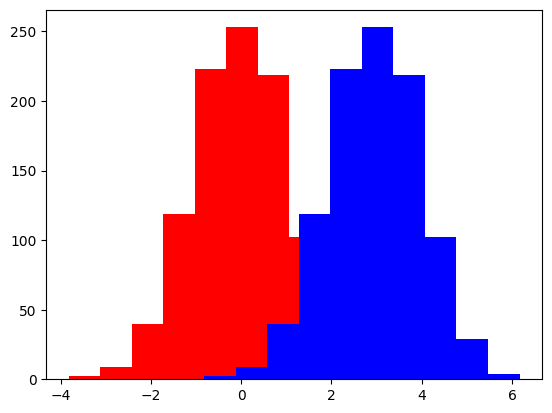

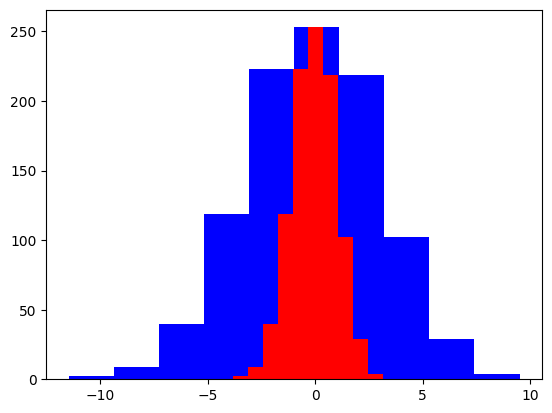

In [ ]:
x = np.random.normal(size = 1000)
c = 3 # Si c > 1, lo hincha, sino lo achica

plt.hist(x, color = "red")
plt.hist(x+c, color = "blue")

plt.figure()
plt.hist(c*x, color = "blue")
plt.hist(x, color = "red")

In [ ]:
# Estadisticos resumen

iris = datasets.load_iris()

df = pd.DataFrame(iris.data, columns = iris.feature_names)

species = [iris.target_names[i] for i in iris.target]
#species = iris.target.astype(str)
df["species"] = species

df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [ ]:
df.drop("species", axis=1).quantile([0.25,0.5,0.75])

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0.25,5.1,2.8,1.60,0.3
0.50,5.8,3.0,4.35,1.3
0.75,6.4,3.3,5.10,1.8


(array([37., 13.,  0.,  3.,  8., 26., 29., 18., 11.,  5.]),
 array([1.  , 1.59, 2.18, 2.77, 3.36, 3.95, 4.54, 5.13, 5.72, 6.31, 6.9 ]),
 <BarContainer object of 10 artists>)

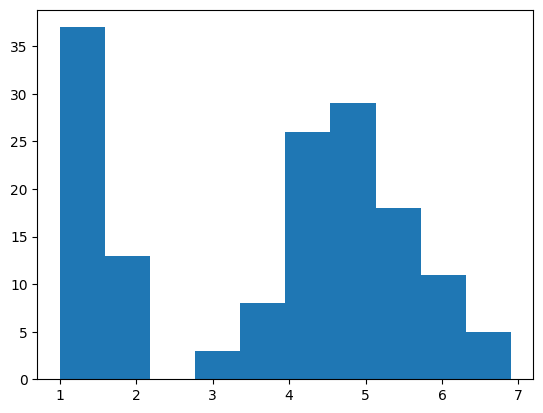

In [ ]:
plt.hist(df["petal length (cm)"].values)

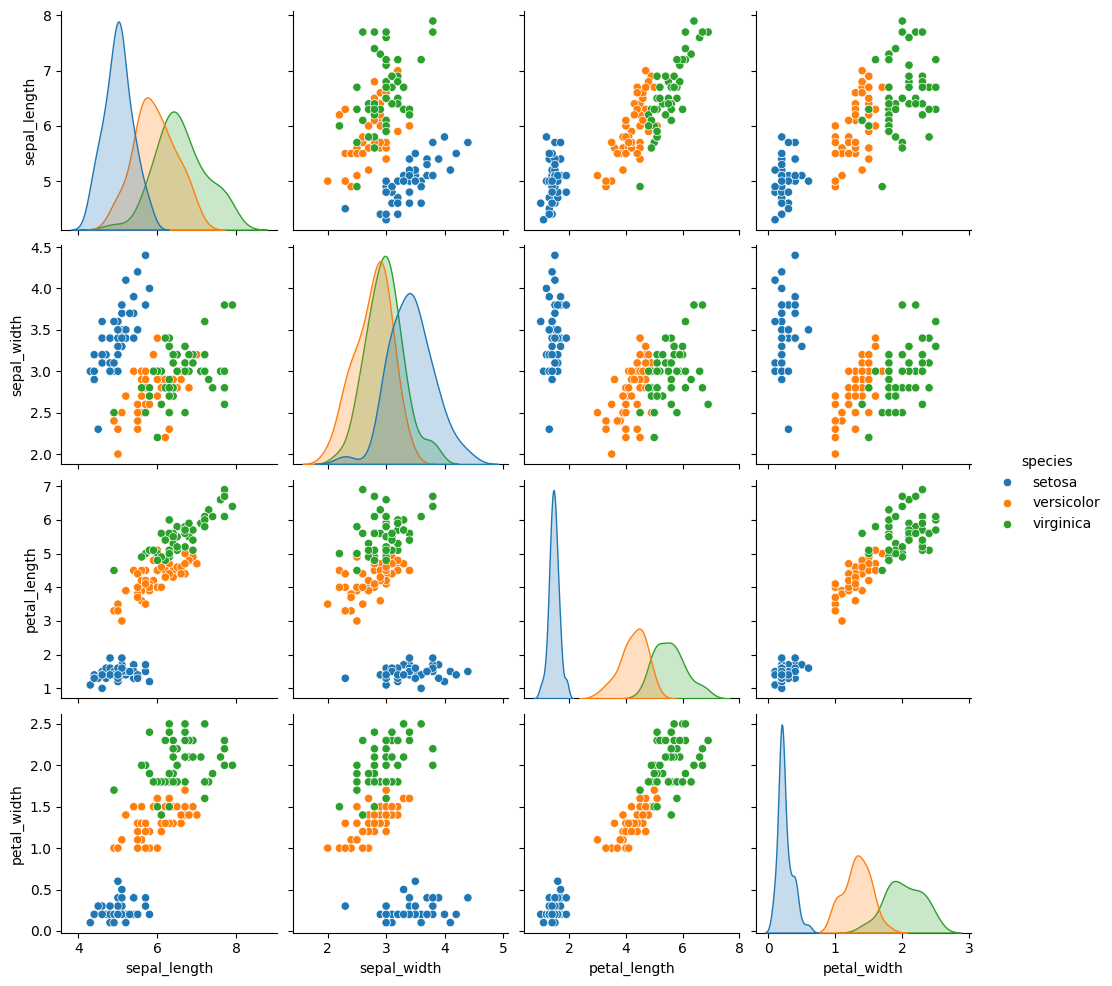

In [ ]:
iris = sns.load_dataset("iris")
df = pd.DataFrame(iris)
sns.pairplot(df, hue="species")

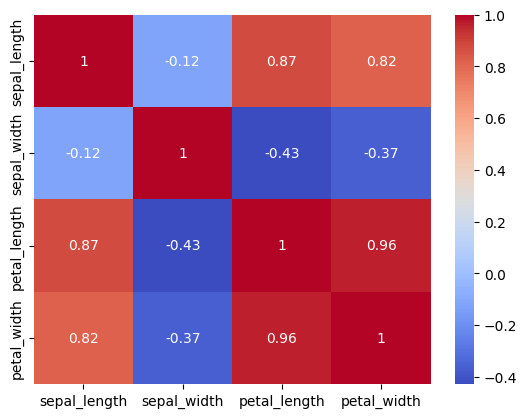

In [ ]:
# Eliminar la columna 'species' ya que no es numérica
iris_numeric = iris.drop(columns=['species'])

# Crear el heatmap de la matriz de correlación
sns.heatmap(iris_numeric.corr(), annot=True, cmap="coolwarm")
plt.show()

In [ ]:
df.drop("species", axis=1).corr(method = "spearman")

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.166778,0.881898,0.834289
sepal_width,-0.166778,1.000000,-0.309635,-0.289032
petal_length,0.881898,-0.309635,1.000000,0.937667
petal_width,0.834289,-0.289032,0.937667,1.000000


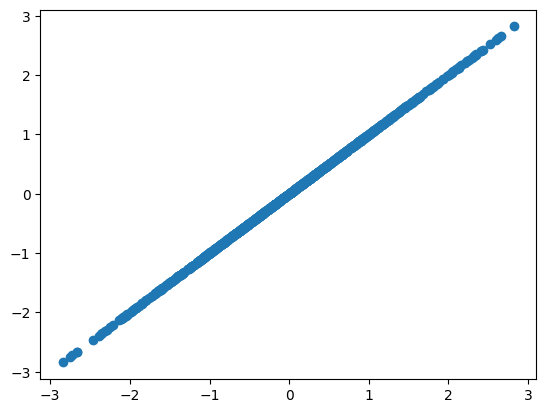

In [ ]:
rho = 1
x= np.random.multivariate_normal(mean=[0,0], cov=[[1,rho],[rho,1]], size = 1000)

plt.scatter(x[:,0], x[:,1])
plt.plot(x[-1,-1],x[-1,-1],color="red")

Clase 3

Breakdown point: alpha

In [ ]:
np.random.seed(47)

x = np.random.normal(size = 100, loc=5)
np.mean(x)

4.994198831920716

In [ ]:
def mean(x) -> float:
  return sum(x)/len(x)

print(f"Mean: {mean(x)}")

def sq_mean(x) -> float:
  return np.sqrt(sum(x**2)/len(x))

print(f"Square mean: {sq_mean(x)}")

def geo_mean(x) -> float:
  return (np.prod(x))**(1/len(x))

print(f"Geometric mean: {geo_mean(x)}")

def w_mean(w, x) -> float:
  if np.round(sum(w),3) != 1.000:
    raise ValueError("Weights must sum to 1")
  return sum((x*w))

print(f"Weighted mean: {w_mean(x/sum(x), x)}")

def trim_mean(x, alpha) -> float:
  if alpha >= 0.5 or alpha <= 0:
    raise ValueError("Alpha must be less than 0.5 and greater than 0")
  p = (alpha/2)*len(x)
  return np.mean(np.sort(x)[int(p):-int(p)])
  #mal: return sum(np.sort(x)[int(p):-int(p)])/(len(x)-2*p)

print(f"Trim mean: {trim_mean(x, 0.05)}")

def median(x):
  n = len(x)
  x = sorted(x)
  if n % 2 == 1:
    return x[(n+1)//2-1]
    #return sorted(x)[round(0.5*(n-1))]
  else:
    return (x[n//2] + x[n//2-1])/2

print(f"Median: {median(x)}")

def sd(x):
  x_bar = sum(x)/len(x)
  #return np.sqrt(sum((x-x_bar)**2)/len(x))
  return ((sum((x-x_bar)**2)/(len(x)-1))**(1/2))

print(f"Standar Deviation: {sd(x)}")

def mad(x, k = 1/0.6745):
  x_tilde = median(x)
  #return np.sqrt(sum((x-x_bar)**2)/len(x))
  return k*median(np.abs(x-x_tilde))

print(f"MAD: {mad(x, k=1)}")

Mean: 4.9941988319207145
Square mean: 5.103617837078383
Geometric mean: 4.872517747808984
Weighted mean: 5.215434127384809
Trim mean: 4.996467534424435
Median: 5.163144892896526
Standar Deviation: 1.0564343756652643
MAD: 0.6587714692788986


Ejercicios

<Axes: ylabel='Count'>

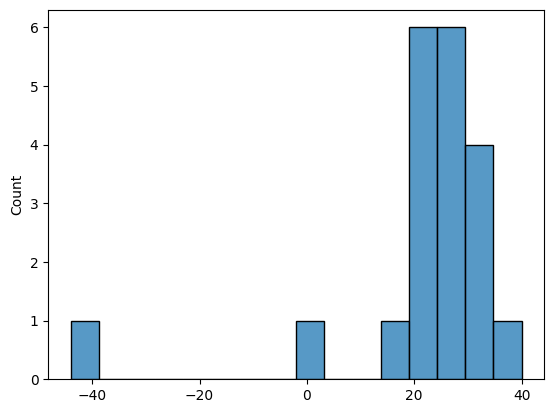

In [ ]:
#x=[28,26,33,24,34,16,40,-2,29,22,25,30,23,29,31,-44,27]
x=np.array([28,16,25,26,40,30,33,-2,23,24,29,29,34,22,31,-44,24,19,27,21])

sns.histplot(x)
#px.histogram(x)

In [ ]:
print(f"Mean: {mean(x)}")
print(f"Square mean: {sq_mean(x)}")
print(f"Geometric mean: {geo_mean(x)}")
w=np.random.uniform(1,100,size=len(x)); w/=sum(w);
print(f"Weighted mean: {w_mean(w, x)}")
alpha = 0.2
print(f"Alpha: {alpha}. Trim mean: {trim_mean(x, alpha)}")
print(f"Mediana (Q2): {median(x)}")
print(f"Standar Deviation: {sd(x)}")
print(f"MAD: {mad(x)}")

Mean: 21.75
Square mean: 27.7173231030704
Geometric mean: nan
Weighted mean: 23.24786386579544
Alpha: 0.2. Trim mean: 25.4375
Mediana (Q2): 25.5
Standar Deviation: 17.627356132174963
MAD: 5.930318754633062


<ipython-input-14-f3c9e05bd10b>:12: RuntimeWarning: invalid value encountered in power
  return (np.prod(x))**(1/len(x))


In [ ]:
#
x=np.array([28,16,25,26,40,30,33,23,24,29,29,34,22,31,24,19,27,21])

def mad(x, k = 1/0.6745):
  x_tilde = median(x)
  #return np.sqrt(sum((x-x_bar)**2)/len(x))
  return k*median(np.abs(x-x_tilde))

print(f"Sd: {sd(x)}")
print(f"MAD: {mad(x, k=1)}")
#

Sd: 5.7986363057649974
MAD: 3.5


Hacer la exponencial y leer el articulo con las tablitas: https://www.mdpi.com/2227-7390/8/8/1259

**Clase 4**

<Axes: ylabel='Count'>

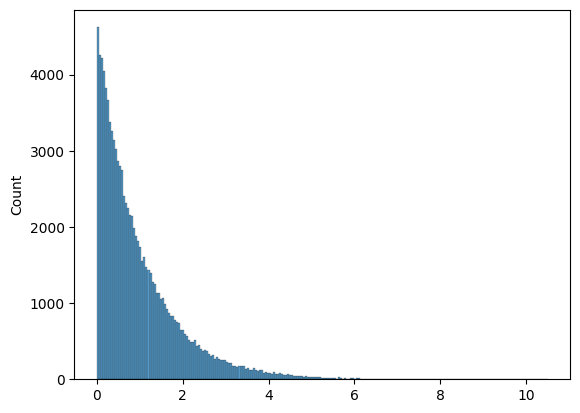

In [ ]:
np.random.seed(123)
x = np.random.exponential(scale = 1, size=100000)
sns.histplot(x)

In [ ]:
sigma = sd(x)
print(f"Desviacion estandar: {sigma}")

md = mad(x, k=1)
print(f"MAD: {md}")

k = sigma/md
print(f"coeficiente de correccion: {k}")

Desviacion estandar: 0.9984575888538709
MAD: 0.48226905841391765
coeficiente de correccion: 2.0703330877945803


<Axes: ylabel='Count'>

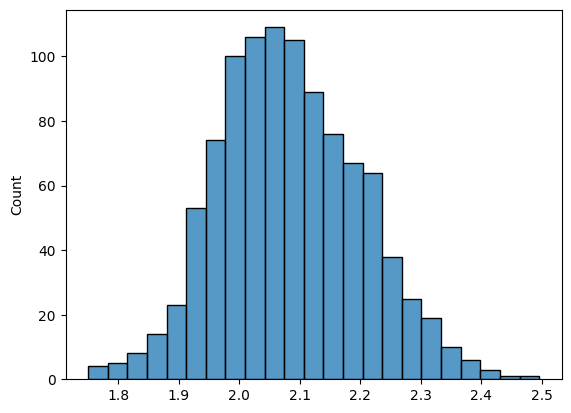

In [ ]:
N = 1000
k = np.zeros(N)
for i in range(N):
  x = np.random.exponential(scale = 1, size=1000)
  k[i] = sd(x)/mad(x, k=1)

sns.histplot(k)

In [ ]:
x = np.random.chisquare(df = 30, size=10000)

sigma = sd(x)
print(f"Desviacion estandar: {sigma}")

md = mad(x, k=1)
print(f"MAD: {md}")

k = sigma/md
print(f"coeficiente de correccion: {k}")

Desviacion estandar: 7.786450751005584
MAD: 5.176222662858905
coeficiente de correccion: 1.5042727599173664


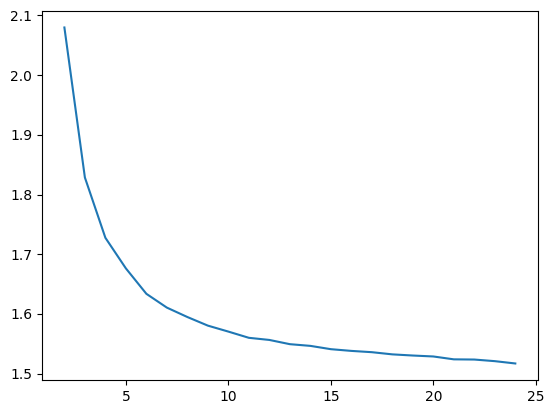

In [ ]:
N = 1000
k = np.zeros(N)
DF = range(2,25)
k_mean = np.zeros(len(DF))

for j, df in enumerate(DF):
  for i in range(N):
    x = np.random.chisquare(df = df, size=1000)
    k[i] = sd(x)/mad(x, k=1)
  k_mean[j] = np.mean(k)

plt.plot(DF, k_mean)

Hacer un metodo numerico con la distribucion X^2:

https://es.wikipedia.org/wiki/Distribuci%C3%B3n_%CF%87%C2%B2


sigma(x) = sd(x)

Cov(x,y) = (sum_i=1^n (xi-x_)(yi-y_))/(n-1)

rho = p = pearson = cov(x,y)/(sd(x)*sd(y))

sigma_x(x) = K_x*MAD(x)

p_r = cov(x,y)/(K_x*MAD(x)*K_y*MAD(y))

comedian -> coM(x,y)
p_r = coM(x,y)/(MAD(x)*MAD(y))

In [ ]:
def corr_pearson2(x,y):
  x_bar = np.mean(x)
  y_bar = np.mean(y)
  return (sum((x-x_bar)*(y-y_bar))/(len(x)-1))/(sd(x)*sd(y))

def cov(x,y):
  if len(x) == len(y):
    x_bar = mean(x)
    y_bar = mean(y)
    n = len(x)
    return (sum((x-x_bar)*(y-y_bar))/(n-1))
  else:
    raise ValueError("Los vectores tienen que tener el mismo tamaño")

def corr_pearson(x,y):
  return cov(x,y)/(sd(x)*sd(y))

def com2(x,y):
  return cov(x,y)/(mad(x)*mad(y))

def com(x,y):
  if len(x) == len(y):
    x_median = median(x)
    y_median = median(y)
    return median((x-x_median)*(y-y_median))
  else:
    raise ValueError("Los vectores tienen que tener el mismo tamaño")

def corr_com(x,y):
  return com(x,y)/(mad(x, k=1)*mad(y,k=1))

In [ ]:
x = np.array([3.79,3.56,3.82,3.91,4.53])
y = np.array([4.38,3.20,3.21,2.99,2.41])

print(corr_pearson(x,y))
print(np.corrcoef(x,y))

print(com(x,y))

print(corr_com(x,y))

-0.6090384352785534
[[ 1.         -0.60903844]
 [-0.60903844  1.        ]]
-0.01890000000000006
-1.0


In [ ]:
def rank(x):
  x_rank2 = []
  x_sort = sorted(x)
  for i in range(len(x)):
    x_rank2.append(x_sort.index(x[i])+1)

  return np.array(x_rank2)


def rho_spearman(x,y):
  n = len(x)
  return 1-(6*sum((rank(x)-rank(y))**2))/(n*(n**2-1))

print(rho_spearman(x,y))
print(scipy.stats.spearmanr(x,y))

-0.7
SignificanceResult(statistic=-0.7, pvalue=0.1881204043741873)


Programar el Tau de Kendall

In [ ]:
from scipy.stats import kendalltau

rhos = np.linspace(-1,1,200)

pearsons = []
spearmans = []
kendalls = []
comedians = [] #!!!!!

for rho in rhos:
  cor_matrix = [[1, rho],
                [rho, 1]]

  x = np.random.multivariate_normal(mean=[0,0], cov=cor_matrix, size = 999+1)
  pearsons.append(corr_pearson(x[:,0],x[:,1]))
  spearmans.append(rho_spearman(x[:,0],x[:,1]))
  kendalls.append(kendalltau(x[:,0], x[:,1])[0])

#plt.scatter(x[:,0], x[:,1])

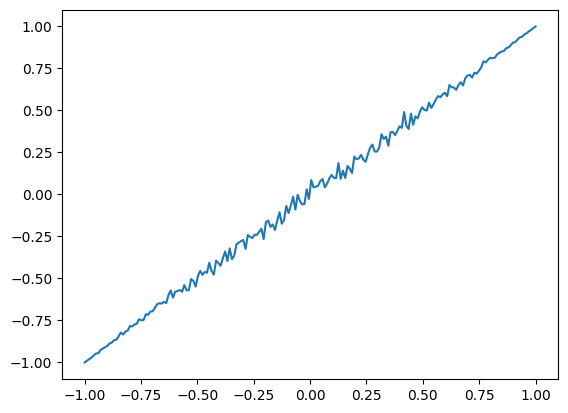

In [ ]:
plt.plot(rhos, pearsons, label = "Pearson")

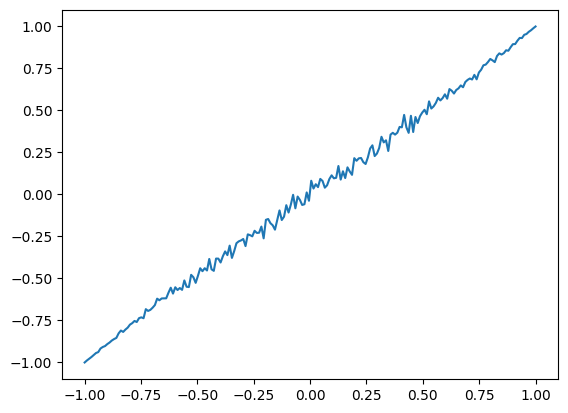

In [ ]:
plt.plot(rhos, spearmans, label = "Spearmans")

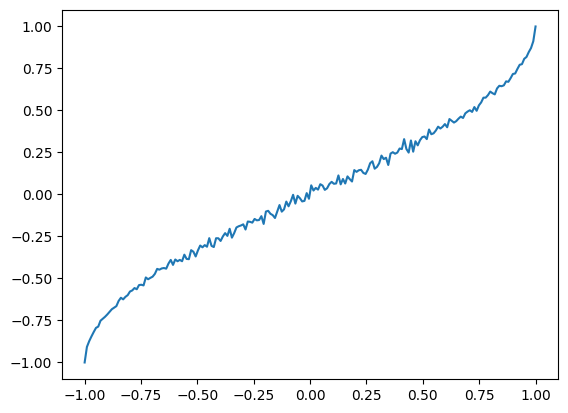

In [ ]:
plt.plot(rhos, kendalls, label = "Kendalls-Tau")

1. Hacerlo con medianas
2. Lo de la exponencial pero con chi

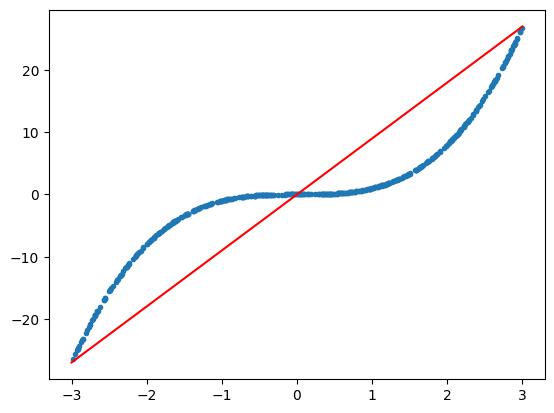

In [ ]:
x = np.random.uniform(-3, 3, size = 500)
y = x**3
plt.plot(x, y, '.')
plt.plot([-3, 3], [-27, 27], color = "red")

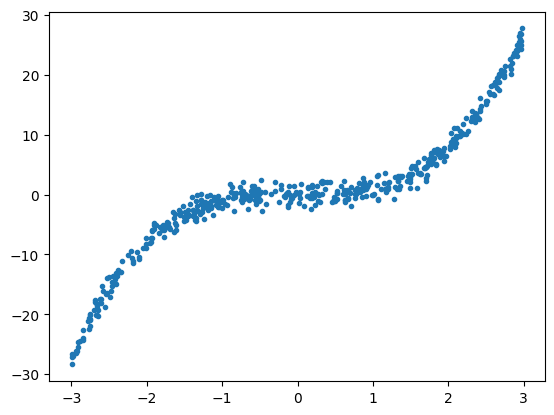

In [ ]:
x = np.random.uniform(-3, 3, size = 500)
y = x**3+np.random.normal(0, scale = 1, size=500)
plt.plot(x, y, '.')

In [ ]:
print(corr_pearson(x,y))
print(rho_spearman(x,y))
print(kendalltau(x, y)[0])

0.9050523461654953
0.9583568574274297
0.8585490981963927


Programar Jackknife


In [ ]:
np.random.seed(123)
x = np.random.normal(size = 100)

def T(x):
  return mean(x)

In [ ]:
from pickle import FALSE
def bias_jackknife(x, T, robust=False):
  n = len(x)
  Tn = T(x)

  T_mean = []
  for i in range(n):
    lista = list(x)
    lista.pop(i)
    T_mean.append(T(np.array(lista)))

  if (robust == False):
    Tn_bar = mean(np.array(T_mean))
  else:
    Tn_bar = median(np.array(T_mean))

  b_jack = (n-1)*(Tn_bar-Tn)
  return b_jack

b_jack = bias_jackknife(x, T)
print(b_jack)

3.434752482434078e-16


In [ ]:
def jackknife_estimator(x, T):
  Tn = T(x)
  n = len(x)
  T_tildes = []
  for i in range(len(x)):
    lista = list(x)
    lista.pop(i)
    T_tildes.append(n*Tn-(n-1)*T(np.array(lista)))

  return T_tildes

x = np.random.normal(loc = 10, size = 50)
Ts = jackknife_estimator(x, T)

(array([ 4.,  1.,  5., 10.,  7., 12.,  3.,  5.,  2.,  1.]),
 array([ 7.97495424,  8.43728921,  8.89962418,  9.36195914,  9.82429411,
        10.28662908, 10.74896405, 11.21129902, 11.67363399, 12.13596896,
        12.59830393]),
 <BarContainer object of 10 artists>)

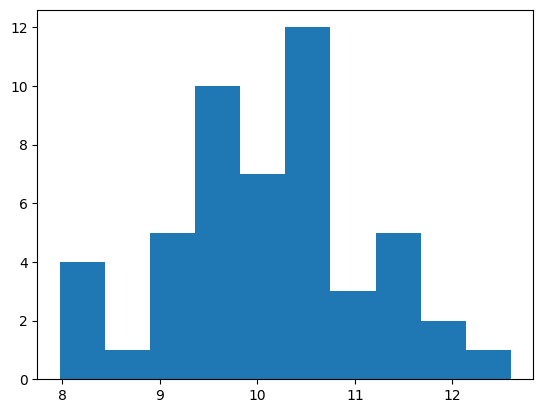

In [ ]:
plt.hist(Ts)

In [ ]:
def T(x):
  return sd(x)

def jackknife_estimator(x, T):
  Tn = T(x)
  n = len(x)
  T_tildes = []
  for i in range(len(x)):
    lista = list(x)
    lista.pop(i)
    T_tildes.append(n*Tn-(n-1)*T(np.array(lista)))

  T_tildes = np.array(T_tildes)
  T_jack = mean(T_tildes)

  s2_tilde = sum((T_tildes - mean(T_tildes))**2)/(n-1)
  Var_T_jack = s2_tilde/n

  return ({"T_tildes": T_tildes, "Estimator": T_jack, "Var_estimador": Var_T_jack})

x = np.random.normal(loc = 10, size = 1000)
Ts = jackknife_estimator(x, T)
#plt.hist(Ts)
#print(Ts)

Clase semana 7:

1.   Newton rhapson
2.   Derivada numerica
3.   Teorema 3.5
4.   programar los percentiles
5.   Pivotal intervals

Estimador Jacknife para sd: 0.9808
Varianza del estimador: 0.0005


(array([760., 134.,  64.,  23.,   9.,   5.,   2.,   2.,   0.,   1.]),
 array([0.48989218, 1.16103997, 1.83218775, 2.50333553, 3.17448331,
        3.8456311 , 4.51677888, 5.18792666, 5.85907444, 6.53022222,
        7.20137001]),
 <BarContainer object of 10 artists>)

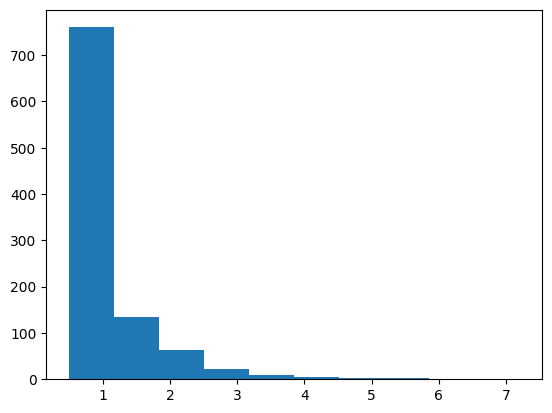

In [ ]:
print(f"Estimador Jacknife para sd: {round(Ts['Estimator'],4)}")
print(f"Varianza del estimador: {round(Ts['Var_estimador'],4)}")
plt.hist(Ts["T_tildes"])

In [ ]:
def bootstrap_estimator(x, T, B = 500):
  n = len(x)
  x = np.array(x)
  T_boots = []

  for _ in range(B):
    x_resample = np.random.choice(x, size = n)
    T_boots.append(T(x_resample))

  T_boots = np.array(T_boots)

  T_boot = mean(T_boots)
  var_boot = mean((T_boots - mean(T_boots))**2)
  return ({"distro": T_boots, "Estimador": T_boot, "VarEstimator": var_boot})

boots = bootstrap_estimator(x, T)

Estimador Boostrap para sd: 0.9802
Varianza del estimador: 0.0005


(array([  5.,  15.,  46.,  74., 110., 114.,  79.,  42.,  13.,   2.]),
 array([0.91350091, 0.92697064, 0.94044037, 0.95391009, 0.96737982,
        0.98084955, 0.99431928, 1.00778901, 1.02125874, 1.03472846,
        1.04819819]),
 <BarContainer object of 10 artists>)

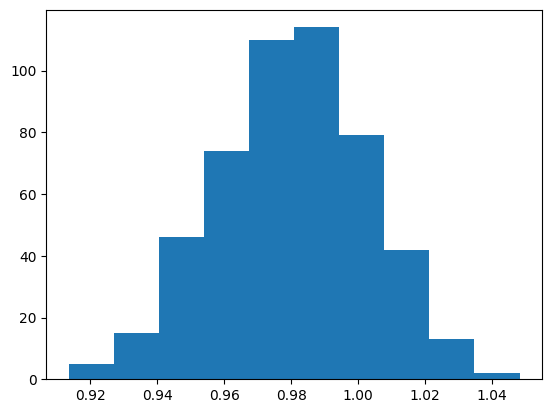

In [ ]:
x = np.random.normal(loc = 10, scale = 1, size = 1000)
T = sd
print(f"Estimador Boostrap para sd: {round(boots['Estimador'],4)}")
print(f"Varianza del estimador: {round(boots['VarEstimator'],4)}")
plt.hist(boots["distro"])

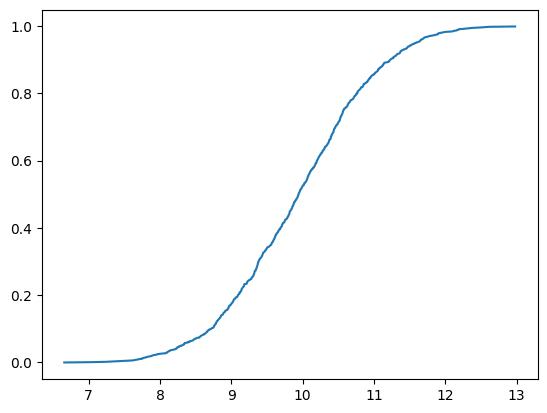

In [ ]:
def ECDF(x):
  n = len(x)
  x = sorted(x)
  ECDF_list = []
  for i in range(len(x)):
    ECDF_list.append(i/n)
  return [x, ECDF_list]

ecdf = ECDF(x)
plt.plot(ecdf[0], ecdf[1])

Estimador puntual: 10.0389
Varianza del estimador: 0.0019
I.C 95%: [9.839, 10.057]


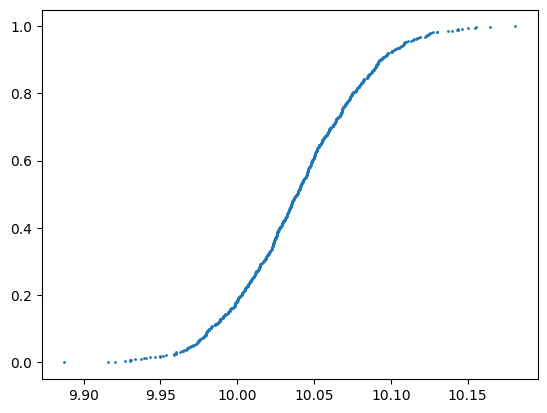

In [ ]:
def T(x):
  return mean(x)

B = 735
x = np.random.normal(loc = 10, size = 500)
median_boot = bootstrap_estimator(x, T, B = B)
median_ecdf = ECDF(median_boot["distro"])

print(f"Estimador puntual: {round(median_boot['Estimador'],4)}")
print(f"Varianza del estimador: {round(median_boot['VarEstimator'],4)}")
print(f"I.C 95%: [{round((9.843105+9.834579)/2, 3)}, {round((10.058687+10.055648)/2	, 3)}]")
plt.scatter(median_ecdf[0], median_ecdf[1], s=1)

In [ ]:
# Calcula el percentil de un conjunto de datos
def percentile(data, percent):
    if percent < 0 or percent > 100:
        raise ValueError("Percent debe estar entre 0 y 100")

    data = np.sort(data)
    index = (len(data) - 1) * (percent / 100)
    lower = int(np.floor(index))
    upper = int(np.ceil(index))

    if lower == upper:
        return data[lower]
    else:
        return data[lower] + (data[upper] - data[lower]) * (index - lower)

# Calcula el intervalo de confianza del 95% de un estimador basado en la distribución bootstrap
def confidence_interval(bootstrap_dist, confidence=0.95):
    lower_percentile = (1 - confidence) / 2
    upper_percentile = 1 - lower_percentile
    ci_lower = percentile(bootstrap_dist, lower_percentile * 100)
    ci_upper = percentile(bootstrap_dist, upper_percentile * 100)
    return (ci_lower, ci_upper)

# Calcular el intervalo de confianza
ci_lower, ci_upper = confidence_interval(median_boot["distro"])
print(f"I.C 95%: [{round(ci_lower, 3)}, {round(ci_upper, 3)}]")

I.C 95%: [9.959, 10.124]


In [ ]:
def bootstrap_estimator(x, T, B=1000):
    n = len(x)
    T_boots = []

    # Resample B times and compute the estimator each time
    for _ in range(B):
        x_resample = np.random.choice(x, size=n, replace=True)
        T_boots.append(T(x_resample))

    return np.array(T_boots)  # Ensure the output is an array

# Perform the bootstrap
B = 1000
bootstrap_medians = bootstrap_estimator(x, np.median, B)

# Check the dimensions and content of bootstrap_medians
print(f"Shape of bootstrap_medians: {bootstrap_medians.shape}")
print(f"Example values: {bootstrap_medians[:10]}")

# Sort the bootstrap distribution
sorted_medians = np.sort(bootstrap_medians)

# Calculate the percentiles
percentiles = np.linspace(0, 1, len(sorted_medians))

# Create a DataFrame to display the values with their percentiles
df = pd.DataFrame({
    'Value': sorted_medians,
    'Percentile': percentiles
})

# Print the DataFrame to manually inspect percentiles (limit the rows printed for clarity)
#print(df.head(10))  # First 10 rows
#print(df.tail(10))  # Last 10 rows

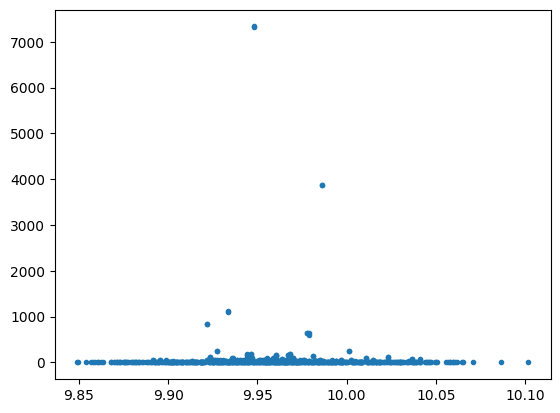

In [ ]:
x = median_ecdf[0]
f = median_ecdf[1]

## suavizar los datos para poder derivar y aproximar la densidad

derivada = []
for i in range(1, len(x)-1):
  dif1 = (f[i] - f[i-1])/(x[i]-x[i-1])
  dif2 = (f[i] - f[i+1])/(x[i]-x[i+1])
  derivada.append(0.5*dif1+0.5*dif2)

plt.plot(x[1:len(x)-1], derivada, '.')

Implementar el spline cúbico para suavizar la curva

In [ ]:
def my_spline(x, y, d):
    try:
        n = len(x)
        A = np.zeros(((d + 1) * (n - 1), (d + 1) * (n - 1)))
        b = np.zeros(((d + 1) * (n - 1), 1))
        cua = np.power(x, 2)
        cub = np.power(x, 3)

        if d == 3:  # Cubic
            A, b = construct_cubic_spline(x, y, n, A, b, cua, cub)
            val = np.linalg.inv(A).dot(b)
            tabla = np.reshape(val, (n - 1, d + 1))
            return tabla.tolist()

    except np.linalg.LinAlgError as e:
        raise ValueError(f"Error al resolver el sistema")
        return ["Error al resolver el sistema"]

def construct_cubic_spline(x, y, n, A, b, cua, cub):
    c = 0
    h = 0
    for i in range(0, n - 1):
        A[h, c] = cub[i]
        A[h, c + 1] = cua[i]
        A[h, c + 2] = x[i]
        A[h, c + 3] = 1
        b[h] = y[i]
        c += 4
        h += 1

    c = 0
    for i in range(1, n):
        A[h, c] = cub[i]
        A[h, c + 1] = cua[i]
        A[h, c + 2] = x[i]
        A[h, c + 3] = 1
        b[h] = y[i]
        c += 4
        h += 1

    c = 0
    for i in range(1, n - 1):
        A[h, c] = 3 * cua[i]
        A[h, c + 1] = 2 * x[i]
        A[h, c + 2] = 1
        A[h, c + 4] = -3 * cua[i]
        A[h, c + 5] = -2 * x[i]
        A[h, c + 6] = -1
        b[h] = 0
        c += 4
        h += 1

    c = 0
    for i in range(1, n - 1):
        A[h, c] = 6 * x[i]
        A[h, c + 1] = 2
        A[h, c + 4] = -6 * x[i]
        A[h, c + 5] = -2
        b[h] = 0
        c += 4
        h += 1

    A[h, 0] = 6 * x[0]
    A[h, 1] = 2
    b[h] = 0
    h += 1
    A[h, c] = 6 * x[-1]
    A[h, c + 1] = 2
    b[h] = 0

    return A, b

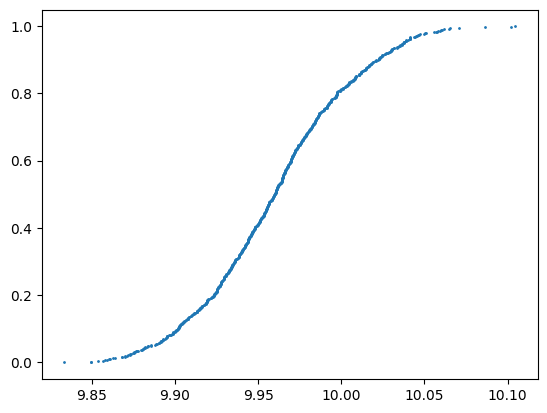

In [ ]:
median_ecdf[0].sort()
x_spline = my_spline(median_ecdf[0], median_ecdf[1], 3)
plt.scatter(median_ecdf[0], median_ecdf[1], s=1)

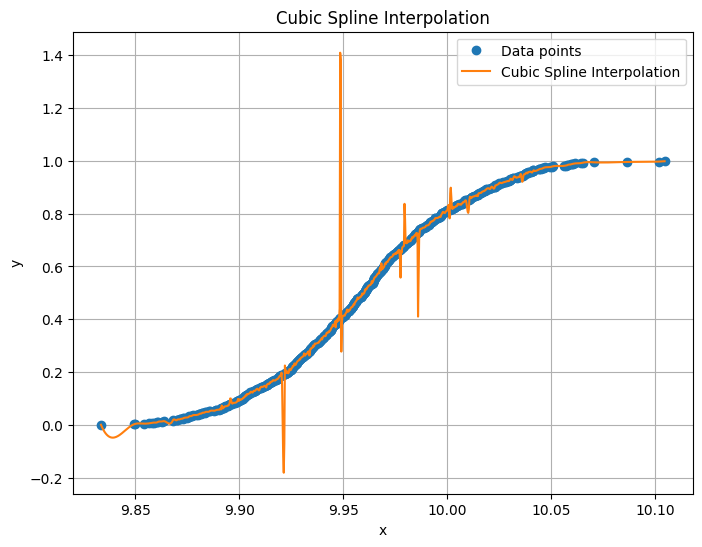

In [ ]:
x_ee = []
y_ee = []

def cubic_spline_interpolation(x, y):
    """
    Perform cubic spline interpolation on given data points and plot the result.

    Parameters:
    x (array-like): 1D array of x-coordinates of the data points.
    y (array-like): 1D array of y-coordinates of the data points.
    """
    # Ensure x and y are numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)

    # Create a cubic spline interpolation function
    cs = CubicSpline(x, y)

    # Generate a range of x values for plotting
    x_dense = np.linspace(x.min(), x.max(), 1000)

    # Evaluate the spline at the dense x values
    y_dense = cs(x_dense)
    global x_ee
    global y_ee
    x_ee = x_dense.copy()
    y_ee = y_dense.copy()

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'o', label='Data points')
    plt.plot(x_dense, y_dense, '-', label='Cubic Spline Interpolation')
    plt.title('Cubic Spline Interpolation')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

cubic_spline_interpolation(median_ecdf[0], median_ecdf[1])


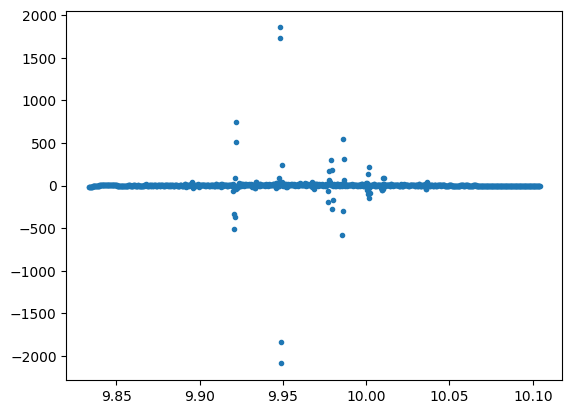

In [ ]:
x = x_ee.copy()
f = y_ee.copy()

### suavizar los datos para poder derivar y aproximar la densidad

derivada = []
for i in range(1, len(x)-1):
  dif1 = (f[i] - f[i-1])/(x[i]-x[i-1])
  dif2 = (f[i] - f[i+1])/(x[i]-x[i+1])
  derivada.append(0.5*dif1+0.5*dif2)

plt.plot(x[1:len(x)-1], derivada, '.')
#print(f)

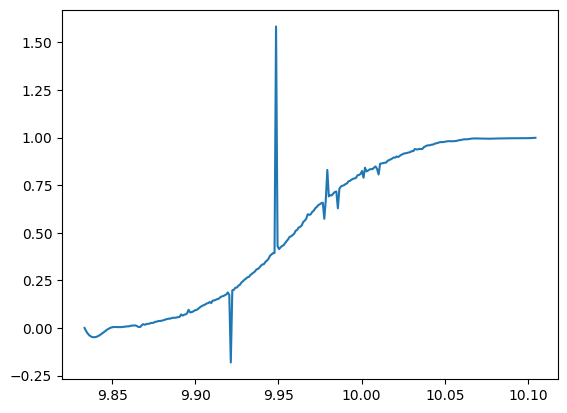

In [ ]:
from scipy.interpolate import make_interp_spline

xnew = np.linspace(x.min(), x.max(), 300)

gfg = make_interp_spline(x, f, k=3)

y_new = gfg(xnew)

plt.plot(xnew, y_new)

plt.show()


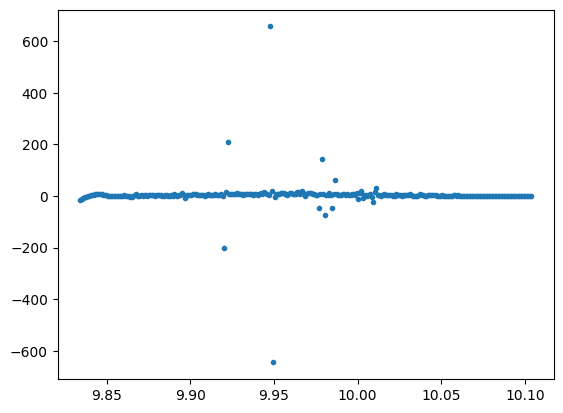

In [ ]:
x = xnew.copy()
f = y_new.copy()

derivada = []
for i in range(1, len(x)-1):
  dif1 = (f[i] - f[i-1])/(x[i]-x[i-1])
  dif2 = (f[i] - f[i+1])/(x[i]-x[i+1])
  derivada.append(0.5*dif1+0.5*dif2)

plt.plot(x[1:len(x)-1], derivada, '.')
#print(f)

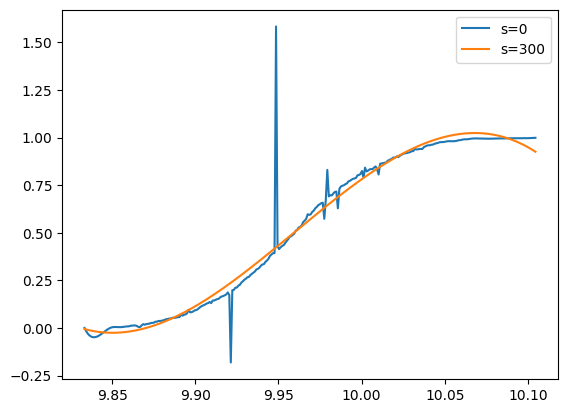

In [ ]:
from scipy.interpolate import splrep, BSpline

tck = splrep(x, f, s=0)
tck_s = splrep(x, f, s=len(x))

plt.plot(xnew, BSpline(*tck)(xnew), '-', label='s=0')
plt.plot(xnew, BSpline(*tck_s)(xnew), '-', label=f's={len(x)}')
plt.legend()
plt.show()

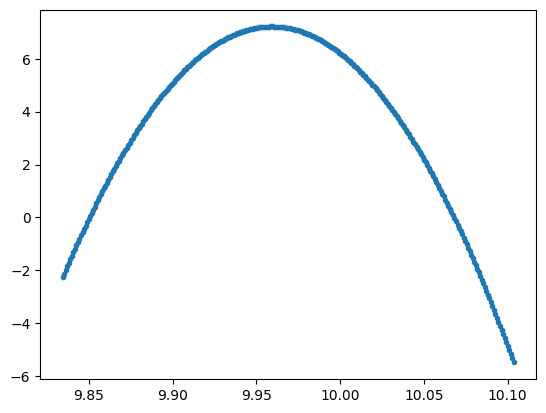

In [ ]:
x = xnew.copy()
f = BSpline(*tck_s)(xnew).copy()

derivada = []
for i in range(1, len(x)-1):
  dif1 = (f[i] - f[i-1])/(x[i]-x[i-1])
  dif2 = (f[i] - f[i+1])/(x[i]-x[i+1])
  derivada.append(0.5*dif1+0.5*dif2)

plt.plot(x[1:len(x)-1], derivada, '.')
#print(f)

Clase 8

Sea (y1,x1), (y2,x2), ...
yi = b_0+b_1*x_i+e_i

e_i ~ normal(0, sigma^2)

1. errores independientes
2. normalidad
3. E[e_i] = 0
4. homocedasticidad


ordinary least squares (OLS)

b^ = argmin(b)(sum_i=1^n{e_i^2})

b^ = argmin(b)(sum_i=1^n{(yi - (b_0+b_1*x_i))^2})



maximum likelihood estimation (MLE)
rho(r) = (1/2)*r^2

(array([  1.,   5.,  19.,  66.,  87., 128.,  95.,  54.,  16.,   8.]),
 array([-17.99021493, -14.52446562, -11.05871631,  -7.592967  ,
         -4.1272177 ,  -0.66146839,   2.80428092,   6.27003023,
          9.73577953,  13.20152884,  16.66727815]),
 <BarContainer object of 10 artists>)

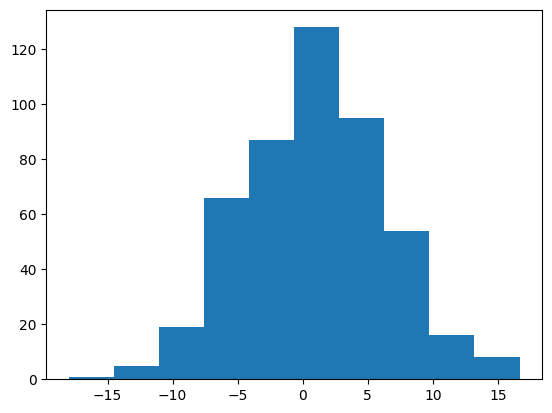

In [ ]:
n = 479
x = np.random.multivariate_normal(mean = [0,0,0], cov = [[1,0,0],[0,1,0],[0,0,1]],size=n)
e = np.random.normal(loc = 0, scale = 1.2, size = n)
y = 1 + 2*x[:,0] + 3*x[:,1] + 4*x[:,2] + e

plt.hist(y)
#plt.plot(x,y, '.')

In [ ]:
# Weighted least squares (WLS)
def WLS(x, y, w = None):
  if (len(x.shape) == 1):
    x = x.reshape(-1,1)

  # Matriz de diseño: matrix "x" aumentada con columna de unos
  X = np.concatenate([np.ones((len(x),1)), x], axis = 1)
  n, p = X.shape
  if w is None:
    w = np.eye(n)

  left = np.linalg.inv(np.matmul(np.matmul(np.transpose(X), w), X))
  right = np.matmul(np.matmul(np.transpose(X), w), y)
  beta = np.matmul(left, right)

  return beta

In [ ]:
n = 1000
x = np.random.multivariate_normal(mean = [0,0,0], cov = [[1,0,0],[0,1,0],[0,0,1]],size=n)
e = np.random.normal(loc = 0, scale = 1.2, size = n)
y = 1 + 2*x[:,0] + 3*x[:,1] + 4*x[:,2] + e

WLS(x,y)

array([0.96943555, 1.97880689, 2.98862977, 3.98168629])

In [ ]:
n = 1000
x = np.random.normal(loc = 0, scale = 2, size = n)
e = np.random.normal(loc = 0, scale = 1.2, size = n)
y = np.sqrt(2) + 5*x + e

WLS(x,y)

array([1.40795264, 4.97343147])

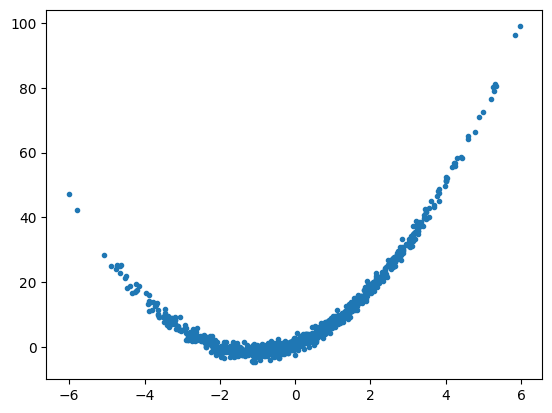

In [ ]:
n = 1000
x = np.random.normal(loc = 0, scale = 2, size = n)
e = np.random.normal(loc = 0, scale = 1.2, size = n)
y = 1 + 2*x**2 + 4.5*x + e

plt.plot(x, y, '.')

In [ ]:
x_tilde = np.concatenate([(x**2).reshape(-1,1), x.reshape(-1,1)], axis = 1)
WLS(x_tilde,y)

array([1.00520493, 1.99486062, 4.50140141])

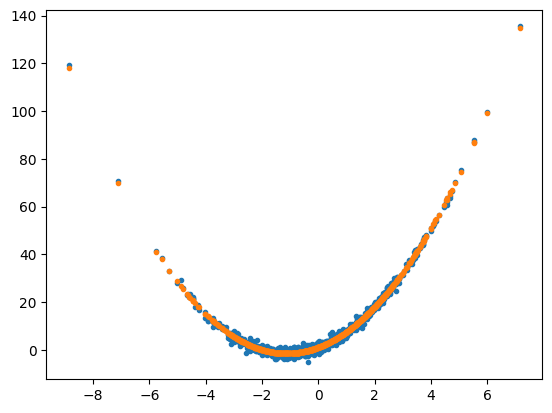

In [ ]:
plt.plot(x,y, '.')
plt.plot(x, WLS(x_tilde,y)[0] + WLS(x_tilde,y)[1]*x**2 + WLS(x_tilde,y)[2]*x, '.')

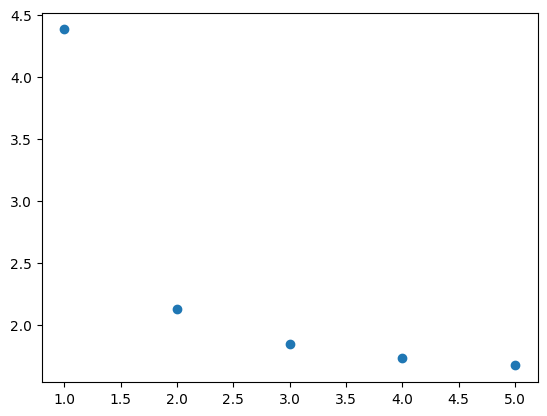

In [ ]:
def g(x):
    # Ensure arguments of gammainc are non-negative
    arg1 = (x + df - 2/3) / 2
    arg2 = (-x + df - 2/3) / 2
    arg1 = max(0.01, arg1)  # Avoid zero or negative values
    arg2 = max(0, arg2)  # Avoid negative values

    # Compute g(x) with valid arguments for gammainc
    return (gammainc(df/2, arg1)) - (gammainc(df/2, arg2)) - 1/2

k2=[]
DF = np.arange(1, 6, 1)
for df in range(1,6):
  x_a = brentq(g, 0.2, 3.1)
  k2.append(np.sqrt(2*df)/x_a)

plt.scatter(DF, k2)

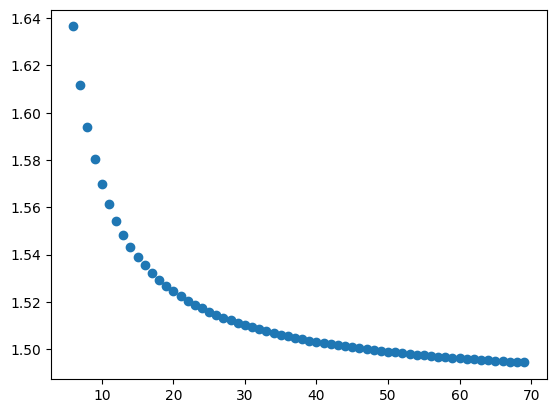

In [ ]:
k1 = []

# Use fsolve instead of newton for more robust root-finding
DF = np.arange(6, 70, 1)
for df in range(6,70):
  x0 = 1
  #g = (gammainc(df/2, (x+df-2/3)/2))/(math.gamma(df/2))-(gammainc(df/2, (-x+df-2/3)/2))/(math.gamma(df/2))
  x_a = brentq(g, 2, 50)
  k1.append(np.sqrt(2*df)/x_a)

plt.scatter(DF, k1)

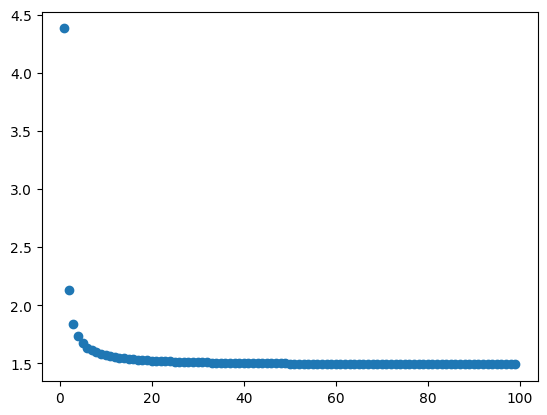

In [ ]:
DF = np.arange(1, 100, 1)
plt.scatter(DF, k2+k1)

v_jack / sigma_n_squared = 0.9965511709730087


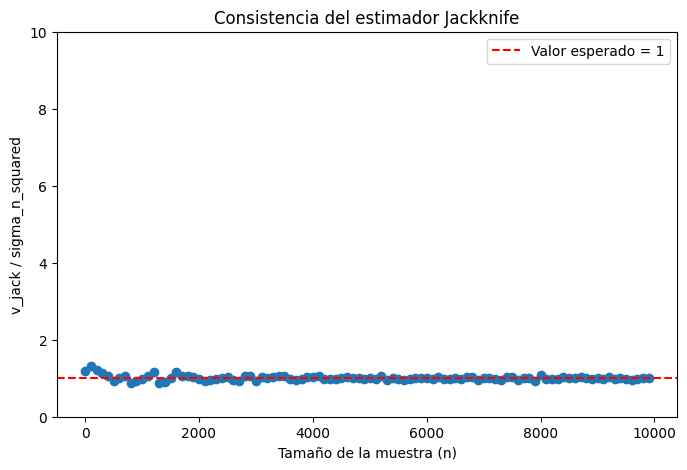

In [ ]:
# Parámetros
n = 1000  # Tamaño de la muestra
mu = 0    # Media verdadera
sigma = 1 # Desviación estándar verdadera

# Generar muestra aleatoria
np.random.seed(42)  # Para reproducibilidad
X = np.random.normal(mu, sigma, n)

# Definir la función g y su derivada en mu
def g(x):
    return np.exp(x)

def g_prime(mu):
    return np.exp(mu)

# Calcular Tn y g(mu)
X_bar = np.mean(X)
Tn = g(X_bar)
g_mu = g(mu)

# Calcular sigma_n^2
sigma_n_squared = (1 / n) * (g_prime(mu))**2 * sigma**2

# Implementar el Jackknife
T_jackknife = np.zeros(n)
for i in range(n):
    # Muestra sin el i-ésimo dato
    X_leave_one_out = np.delete(X, i)
    X_bar_leave_one_out = np.mean(X_leave_one_out)
    T_jackknife[i] = g(X_bar_leave_one_out)

# Calcular el estimador Jackknife de la varianza
v_jack = ((n - 1) / n) * np.sum((T_jackknife - Tn)**2)

# Verificar la consistencia
consistency_ratio = v_jack / sigma_n_squared
print(f"v_jack / sigma_n_squared = {consistency_ratio}")

# Repetir el experimento para diferentes tamaños de muestra
n_values = np.arange(2,10000, 100)
consistency_ratios = []

for n in n_values:
    X = np.random.normal(mu, sigma, n)
    X_bar = np.mean(X)
    Tn = g(X_bar)
    sigma_n_squared = (1 / n) * (g_prime(mu))**2 * sigma**2

    T_jackknife = np.zeros(n)
    for i in range(n):
        X_leave_one_out = np.delete(X, i)
        X_bar_leave_one_out = np.mean(X_leave_one_out)
        T_jackknife[i] = g(X_bar_leave_one_out)

    v_jack = ((n - 1) / n) * np.sum((T_jackknife - Tn)**2)
    consistency_ratio = v_jack / sigma_n_squared
    consistency_ratios.append(consistency_ratio)

# Graficar los resultados
plt.figure(figsize=(8, 5))
plt.scatter(n_values, consistency_ratios)
plt.axhline(1, color='r', linestyle='--', label='Valor esperado = 1')
plt.xlabel('Tamaño de la muestra (n)')
plt.ylabel('v_jack / sigma_n_squared')
plt.title('Consistencia del estimador Jackknife')
plt.ylim(0, 10)
plt.legend()
plt.show()

Estimador Boostrap para sd: 1.017


(array([  1.,   6.,   8.,  40.,  92.,  99., 125.,  83.,  32.,  14.]),
 array([0.93284888, 0.94695418, 0.96105948, 0.97516478, 0.98927008,
        1.00337538, 1.01748068, 1.03158599, 1.04569129, 1.05979659,
        1.07390189]),
 <BarContainer object of 10 artists>)

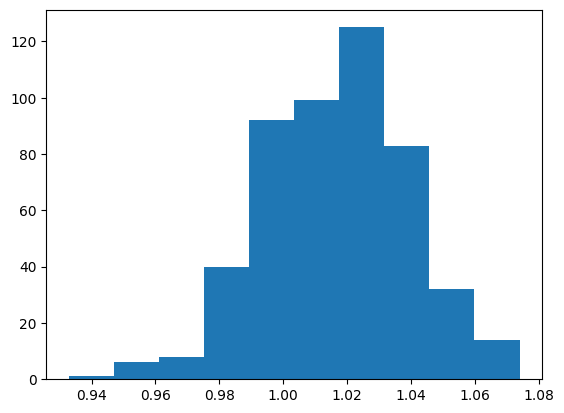

In [ ]:
def bootstrap_estimator(x, T, B = 500):
  n = len(x)
  x = np.array(x)
  T_boots = []

  for _ in range(B):
    x_resample = np.random.choice(x, size = n)
    T_boots.append(T(x_resample))

  T_boots = np.array(T_boots)

  T_boot = mean(T_boots)
  var_boot = mean((T_boots - mean(T_boots))**2)
  return ({"distro": T_boots, "Estimador": T_boot, "VarEstimator": var_boot})

boots = bootstrap_estimator(x, T)

x = np.random.normal(loc = 10, scale = 1, size = 100)
T = sd
print(f"Estimador Boostrap para sd: {round(boots['Estimador'],3)}")
plt.hist(boots["distro"])

In [ ]:
# Normal interval:
low, up = confidence_interval(boots['distro'])
print(f"Intervalo de confianza para sd: [{round(low,3)}, {round(up,3)}]")

Intervalo de confianza para sd: [0.972, 1.061]


In [ ]:
'''# Pivotal Intervals
# Función para calcular el pivote
def calculate_pivots(x, T, B=500):
    boots = bootstrap_estimator(x, T, B)
    T_boots = boots['distro']
    T_boot = boots['Estimador']
    original_estimator = T(x)

    # Calcular pivotes
    pivots = T_boots - original_estimator
    return pivots, T_boot

# Función para calcular el intervalo de confianza pivotal
def pivotal_interval(x, T, B=500, confidence=0.95):
    pivots, original_estimator = calculate_pivots(x, T, B)

    # Intervalo de confianza usando los percentiles del pivote
    ci_lower = original_estimator - percentile(pivots, 100 * (1 - confidence))
    ci_upper = original_estimator - percentile(pivots, 100 * confidence)

    return (ci_lower, ci_upper)'''

In [ ]:
# Función para calcular la CDF empírica H_hat(r) usando los pivotes bootstrap
def bootstrap_pivot_cdf(bootstrap_pivots, r):
    B = len(bootstrap_pivots)
    count = sum(1 for pivot in bootstrap_pivots if pivot <= r)  # Contar cuántos pivotes son <= r
    return count / B  # Aproximación de la CDF empírica

# Calcula los pivotes bootstrap
def bootstrap_pivotal_interval(x, T, B=500, alpha=0.05):
    n = len(x)
    theta_n = T(x)

    # Resampling bootstrap
    T_boots = []
    for _ in range(B):
        x_resample = np.random.choice(x, size=n, replace=True)
        T_boots.append(T(x_resample))

    # Calculamos los pivotes bootstrap
    T_boots = np.array(T_boots)
    R_boots = T_boots - theta_n

    # Cuantiles de los pivotes bootstrap
    r_lower = percentile(R_boots+theta_n, (alpha / 2) * 100)
    r_upper = percentile(R_boots+theta_n, (1 - alpha / 2) * 100)

    # Intervalo pivotal usando los pivotes y cuantiles
    a = 2 * theta_n - r_upper
    b = 2 * theta_n - r_lower

    return a, b

In [ ]:
# Intervalo de confianza pivotal
x = np.random.normal(loc = 10, scale = 1, size = 100)
ci_lower, ci_upper = bootstrap_pivotal_interval(x, sd, B=500, alpha=0.05)
print(f"Intervalo de confianza pivotal para sd: [{round(ci_lower,3)}, {round(ci_upper,3)}]")

Intervalo de confianza pivotal para sd: [0.881, 1.15]


In [ ]:
'''def bootstrap_estimator(x, T, N = 1000):
    x = np.array(x)
    T_boots = []
    n = len(x)
    for i in range(N):
        x_resample = np.random.choice(x,n)
        T_boots.append(T(x_resample))

    T_boots = np.array(T_boots)
    var_boot = mean((T_boots- mean(T_boots))**2)
    return {"Distro": T_boots, "Estimador": mean(T_boots), "VarEstimador": var_boot}

def percentil(data, q):
    data, ecdf_data = ecdf(data)
    for i in range(len(ecdf_data)):
        if ecdf_data[i] >= q:
            return data[i]

def ecdf(x):
    x = sorted(x)
    ecdf = []
    n = len(x)
    for i in range(n):
        ecdf.append(i/n)
    return x, ecdf

### Parte importante
np.random.seed(123)
x = np.random.normal(loc=10, scale = 1, size = 150)
B = 765
T_boot = bootstrap_estimator(x, sd, B)

distrib = T_boot['Distro']
estimator = T_boot['Estimador']
alpha = 0.05
print(2*estimator - percentil(distrib, 1-alpha/2))
print(2*estimator - percentil(distrib, alpha/2))

ci_lower, ci_upper = bootstrap_pivotal_interval(x, sd, B=500, alpha=0.05)
print(f"Intervalo de confianza pivotal para sd: [{round(ci_lower,3)}, {round(ci_upper,3)}]")'''

0.9767660018359772
1.1943249487021759
Intervalo de confianza pivotal para sd: [0.988, 1.201]


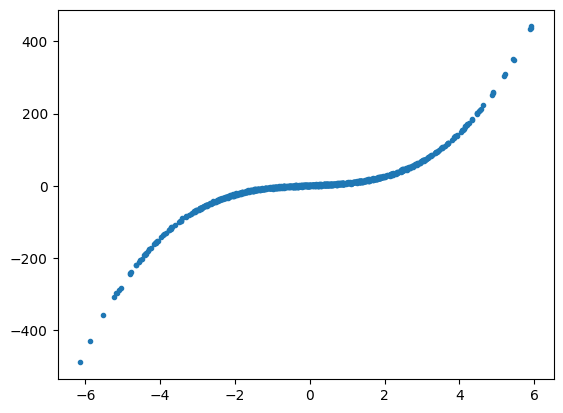

In [ ]:
#Regresión
n = 1000
x = np.random.normal(loc = 0, scale = 2, size = n)
e = np.random.normal(loc = 0, scale = 1.2, size = n)
y = 1 + 2*x**3 + 4.5*x + e

plt.plot(x, y, '.')

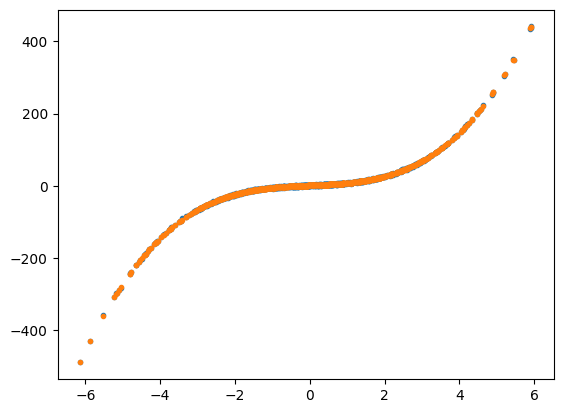

In [ ]:
x_tilde = np.concatenate([(x**3).reshape(-1,1), x.reshape(-1,1)], axis = 1)
WLS(x_tilde,y)
plt.plot(x,y, '.')
plt.plot(x, WLS(x_tilde,y)[0] + WLS(x_tilde,y)[1]*x**3 + WLS(x_tilde,y)[2]*x, '.')

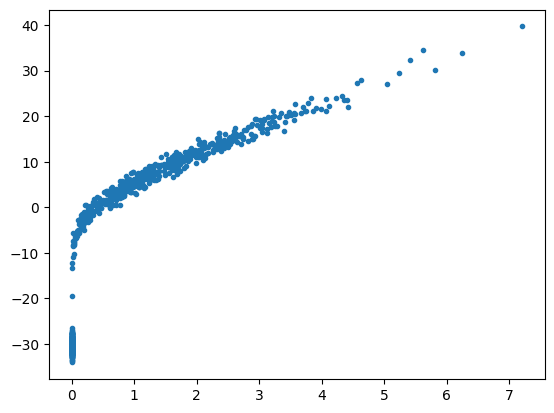

In [ ]:
n = 1000
x = np.random.normal(loc = 0, scale = 2, size = n)
x = np.clip(x, a_min=1e-5, a_max=None)  # Reemplaza los valores cero o negativos con un pequeño número positivo
e = np.random.normal(loc = 0, scale = 1.2, size = n)
y = 1 + math.e*np.log(x) + 4.5*x + e

plt.plot(x, y, '.')

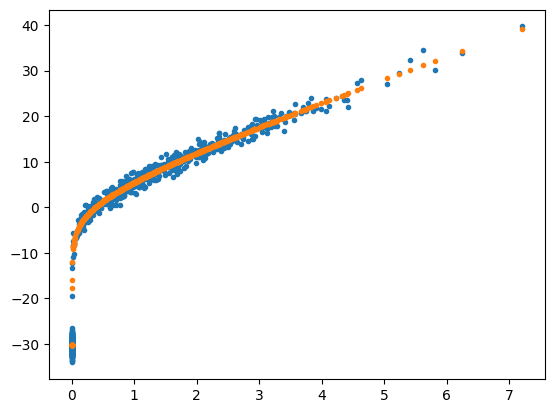

In [ ]:
x_tilde = np.concatenate([np.log(x).reshape(-1,1), x.reshape(-1,1)], axis = 1)
WLS(x_tilde,y)
plt.plot(x,y, '.')
plt.plot(x, WLS(x_tilde,y)[0] + np.log(x)*WLS(x_tilde,y)[1] + WLS(x_tilde,y)[2]*x, '.')

Ultima clase

In [ ]:
n = 500
x1 = np.random.normal(loc = 1, scale = 1, size = n)
x2 = np.random.normal(loc = 2, scale = 2, size = n)
x3 = np.random.normal(loc = 3, scale = 3, size = n)
e = np.random.normal(loc = 0, scale = np.sqrt(2), size = n)

y = 1.20 + 9.76*x1 + 6.89*x2 + 3.53*x3 + e

y2 = 1.20 + 9.76*x1 + e

#plt.plot(x1, y, '.')

### Estimacion de coeficientes de regresion mediante calculo matricial

$$\hat{\beta}=(X^\top X)^{-1}(X^\top Y)$$

In [ ]:
# Matriz de diseño
def OLS(y, X):
  '''
  Esta funcion calcula los coeficientes de regresion usando la
  solucion matricial via OLS del modelo de Regresion Lineal.
    Input:
      y: variable respuesta
      X: Matriz de diseño
    Output:
      betas: vector de coeficientes de regresion
  '''

  betas = np.linalg.inv(np.transpose(X)@X)@np.transpose(X)@y
  return(betas)

OLS(y, X = np.column_stack((np.ones(n),x1,x2,x3)))

array([1.04468722, 9.89920868, 6.93019565, 3.53489838])

In [ ]:
def OLS_sigma(X, y):
  X = np.column_stack([X, y])
  sigma = np.cov(np.transpose(X))
  sigmaXX = sigma[0:3,0:3]
  simgaXY = sigma[0:3,3].reshape(-1,1)

  betaSinCero = np.linalg.inv(sigmaXX)@simgaXY

  media = np.mean(X, axis=0)

  beta0 = media[-1] - media[:-1].dot(betaSinCero)

  betas = np.concatenate([beta0, betaSinCero.reshape(1, -1)[0]])

  return(betas)

X = np.column_stack([x1,x2,x3])
OLS_sigma(X, y)

array([1.04468722, 9.89920868, 6.93019565, 3.53489838])

## M-estimador

In [ ]:
# Funcion de perdida
def huber_rho(errores, c = 1.345):
  rho = []
  for e in errores:
    if np.abs(e) <= c:
      rho.append(e**2/2)
    else:
      rho.append(c*np.abs(e) - (c**2)/2)

  return(np.array(rho))

# Funcion de influencia
def huber_psi(errores, c = 1.345):
  psi = []
  for e in errores:
    if np.abs(e) <= c:
      psi.append(e)
    else:
      psi.append(c*np.sign(e))

  return(np.array(psi))

# Funcion de penalizacion
def huber_w(errores, c = 1.345):
  w = []
  for e in errores:
    if np.abs(e) <= c:
      w.append(1)
    else:
      w.append(0)

  return(np.array(w))

e = np.random.normal(loc = 0, scale = 3, size = 500)
rhos = huber_rho(e)
psis = huber_psi(e)
ws = huber_w(e)

plt.plot(e, rhos, '.')
plt.plot(e, psis, '.')
plt.plot(e, ws, '.')

NameError: name 'np' is not defined

In [ ]:
X = np.column_stack([np.ones(n),x1,x2,x3])

def M_estimator(y, X, tol = 1e-5, iter_max = 100):

  beta_0 = OLS(y, X)
  e = y - X@beta_0
  #plt.hist(e)
  sigma = mad(e)
  e_s = e/sigma
  w_ii = huber_psi(e_s)/e_s
  iter = 0

  while True:
    iter += 1
    W = np.diag(w_ii)
    #beta = (np.linalg.inv(np.transpose(X).dot(W).dot(X)).dot(np.transpose(X)).dot(W).dot(y))
    beta = (np.linalg.inv(X.T@W@X)@X.T@W@y)

    if np.sqrt(sum((beta-beta_0)**2)) < tol:
      break

    if (iter == iter_max):
      break

    beta_0 = beta
    e = y - X@beta
    sigma = mad(e)
    e_s = e/sigma
    w_ii = huber_psi(e_s)/e_s

  print(f"Numero de iteraciones: {iter}")
  return(beta)

In [ ]:
X = np.column_stack([x1,x2,x3])
X[1, :] = [22,25,30]
X[100, :] = [25,39.1,29]
X[465, :] = [30.1,45,12]

X = np.column_stack([np.ones(len(y)), X])

print(M_estimator(y, X))

Numero de iteraciones: 15
[1.67842244 9.60094398 6.80188441 3.50512194]


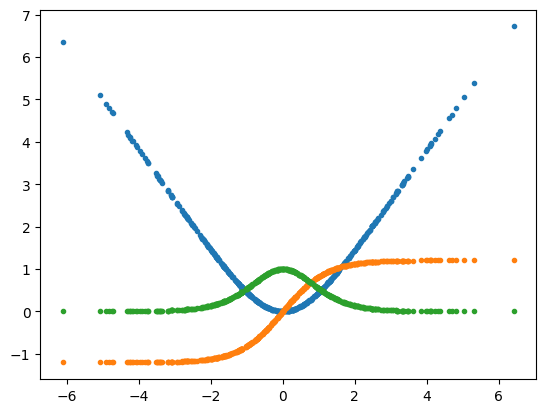

In [ ]:
# Funcion de perdida
def log_rho(errores, c = 1.205):
  rho = []
  for e in errores:
    rho.append((c**2)*np.log(np.cosh(e/c)))

  return(np.array(rho))

# Funcion de influencia
def log_psi(errores, c = 1.205):
  psi = []
  for e in errores:
    psi.append(c*np.tanh(e/c))

  return(np.array(psi))

# Funcion de penalizacion
def log_w(errores, c = 1.205):
  w = []
  for e in errores:
    # derivada de c*np.tanh(x/c) es sech^2(x/c)
    w.append(1/(np.cosh(e/c)**2))

  return(np.array(w))

e = np.random.normal(loc = 0, scale = 2, size = 500)
rhos = log_rho(e)
psis = log_psi(e)
ws = log_w(e)

plt.plot(e, rhos, '.')
plt.plot(e, psis, '.')
plt.plot(e, ws, '.')

In [ ]:
# Matriz de diseño
def OLS(y, X):
  '''
  Esta funcion calcula los coeficientes de regresion usando la
  solucion matricial via OLS del modelo de Regresion Lineal.
    Input:
      y: variable respuesta
      X: Matriz de diseño
    Output:
      betas: vector de coeficientes de regresion
  '''

  betas = np.linalg.inv(np.transpose(X)@X)@np.transpose(X)@y
  return(betas)

# M estimador
def M_estimator(y, X, tol = 1e-10, iter_max = 10000):

  beta_0 = OLS(y, X)
  e = y - X@beta_0
  sigma = mad(e)
  e_s = e/sigma
  w_ii = log_psi(e_s)/e_s
  iter = 0

  while True:
    iter += 1
    W = np.diag(w_ii)
    beta = (np.linalg.inv(X.T@W@X)@X.T@W@y)

    if np.sqrt(sum((beta-beta_0)**2)) < tol:
      break

    if (iter == iter_max):
      break

    beta_0 = beta
    e = y - X@beta
    sigma = mad(e)
    e_s = e/sigma
    w_ii = log_psi(e_s)/e_s

  print(f"Número de iteraciones: {iter}")
  return(beta)

for n in [100, 500, 1000]:
  x1 = np.random.normal(loc = 1, scale = 1, size = n)
  x2 = np.random.normal(loc = 2, scale = 2, size = n)
  x3 = np.random.normal(loc = 3, scale = 3, size = n)
  e = np.random.normal(loc = 0, scale = np.sqrt(2), size = n)

  y = 1.20 + 9.76*x1 + 6.89*x2 + 3.53*x3 + e
  X = np.column_stack([np.ones(n),x1,x2,x3])

  betas = M_estimator(y, X)
  mse = mean_squared_error([1.20, 9.76, 6.89, 3.53], betas)
  mae = mean_absolute_error([1.20, 9.76, 6.89, 3.53], betas)

  print(f"Tamaño de muestra: {n}")
  print(f"Coeficientes estimados: {betas}")
  print(f"Average MSE: {mse}")
  print(f"Average MAE: {mae}\n")

Numero de iteraciones: 16
Tamaño de muestra: 100
Coeficientes estimados: [0.76036345 9.80449683 7.16244067 3.51178153]
Average MSE: 0.0674540232486025
Average MAE: 0.19369812796784863

Numero de iteraciones: 14
Tamaño de muestra: 500
Coeficientes estimados: [1.41664257 9.703494   6.86246014 3.52029244]
Average MSE: 0.012744903542424206
Average MAE: 0.07759900042679363

Numero de iteraciones: 13
Tamaño de muestra: 1000
Coeficientes estimados: [1.30168162 9.75624842 6.87588324 3.51709726]
Average MSE: 0.002679747553732893
Average MAE: 0.03311317549592868



In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
abalone = fetch_ucirepo(id=1)

# data (as pandas dataframes)
X = abalone.data.features
y = abalone.data.targets

# metadata
print(abalone.metadata)

# variable information
print(abalone.variables)


# Clase Final


In [ ]:
from scipy.stats import norm

# Bin-width
def KDE(X):
  sigma_gorro = min(np.std(X), (np.quantile(X, 0.75) - np.quantile(X, 0.25))/1.34)
  n = len(X)
  h = 1.06*sigma_gorro/(n**(1/5))
  x = np.linspace(min(X), max(X), 1000)
  fx = []
  for i in range(len(x)):
    K = norm.pdf((x[i]-X)/h)
    fx.append((1/n)*sum((1/h)*K))
  return([x, np.array(fx)])

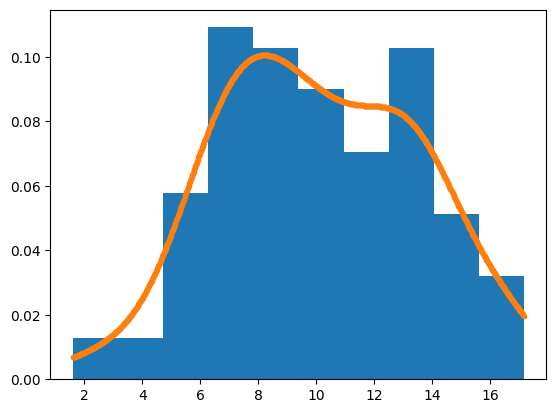

In [ ]:
np.random.seed(123)
X = np.random.normal(loc = 10, scale = 3, size = 100)
plt.hist(X, density=True)
[x, fx] = KDE(X)

plt.plot(x, fx, '.')

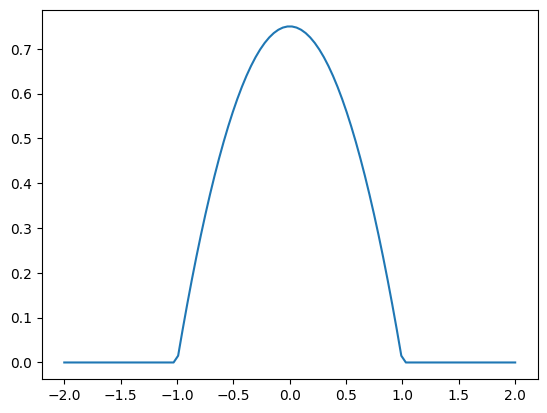

In [ ]:
def epanechnikov(x):
  K = np.zeros(len(x))
  K[abs(x)<1] = (3/4)*(1 - (x[abs(x)<1])**2)
  return(K)

x = np.linspace(-2, 2, 100)
y = epanechnikov(x)
plt.plot(x, y)

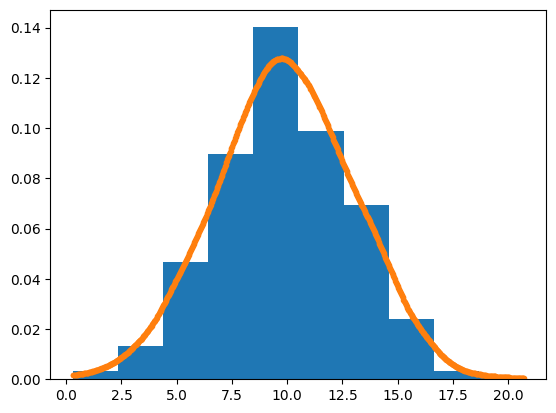

In [ ]:
from scipy.stats import norm

# Bin-width
def KDE(X):
  sigma_gorro = min(np.std(X), (np.quantile(X, 0.75) - np.quantile(X, 0.25))/1.34)
  n = len(X)
  h = 1.06*sigma_gorro/(n**(1/5))
  x = np.linspace(min(X), max(X), 1000)
  fx = []
  for i in range(len(x)):
    K = epanechnikov((x[i]-X)/h)
    fx.append((1/n)*sum((1/h)*K))
  return([x, np.array(fx)])

def epanechnikov(x, c = 3):
  K = np.zeros(len(x))
  K[abs(x)<c] = (3/(4*c))*(1 - (x[abs(x)<c]/c)**2)
  return(K)
'''
x = np.linspace(-5, 5, 100)
y = epanechnikov(x, c = 2)
plt.plot(x, y)
'''
np.random.seed(123)
X = np.random.normal(loc = 10, scale = 3, size = 1000)
plt.hist(X, density=True)
[x, fx] = KDE(X)

plt.plot(x, fx, '.')

Clase FINAL

In [ ]:
# Wilcoxon

X = np.array([34, 36, 41, 39, 44, 37])
Y = np.array([45, 33, 35, 43, 42, 42])

n = len(X)
# Calculo de los rangos y signos
diff = sorted(X - Y, key=abs)
#print(diff)

rank = np.array(range(1, len(diff)+1))

Tp = sum(rank[np.sign(diff) == 1])
Tm = sum(rank[np.sign(diff) == -1])

print(f"Tp = {Tp}")
print(f"Tm = {Tm}")

W = min(Tp, Tm)
mu_W = n*(n+1)/4
sigma_W = np.sqrt((n*(n+1)*(2*n+1)-0)/24)

# Estadisticos de prueba
Z = (W - mu_W)/sigma_W

alpha = 0.05
# valor critico
Z_crit = norm.ppf(1-alpha/2)
print(f"Z_crit = {Z_crit}")

# p valor asociado al estadistico de prueba
p_value = 2*(1-norm.cdf(abs(Z)))
print(f"p-value = {p_value}") # no rechazo

Tp = 8
Tm = 13
Z_crit = 1.959963984540054
p-value = 0.6001794871405539


In [ ]:
# Mann-Whitney

x = np.array([34, 36, 41, 43, 44, 37, 45, 33, 35, 39, 42])
sex = 6*["female"]+5*["male"]

datos = sorted(list(zip(x, sex)))
rank = np.array(range(1, len(datos)+1))

#print(rank)
#print(datos)

T1 = sum(rank[np.array(list(zip(*datos))[1]) == "female"])
T2 = sum(rank[np.array(list(zip(*datos))[1]) == "male"])

#print(T1)
#print(T2)

n1 = sum(np.array(list(zip(*datos))[1]) == "female")
n2 = sum(np.array(list(zip(*datos))[1]) == "male")

U1 = n1*n2+(n1*(n1+1))/2 - T1
U2 = n1*n2+(n2*(n2+1))/2 - T2

U = min(U1, U2)
mu_U = n1*n2/2
sigma_U = np.sqrt((n1*n2*(n1+n2+1))/12)

Z = (U-mu_U)/sigma_U

print(Z)

-0.18257418583505536
